In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
import pandas as pd
from scipy import stats
%matplotlib inline

# Initialisation
## Données

```
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[-1] # JJ   attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot
```

```
wt_real=np.array(analyse_fichier())
wt_real=wt_real[3:,:] # il faut supprimer les deux 1res. !!! Seulement la première (d'ailleurs là tu enlèves les 3 premières)
```

In [2]:
seuil_detection_fitness=0.005

#file="doi_10/All_data/data_microMA/dataset_microMA_MutH.csv"
#wt_real = pd.read_csv(file, 
#                      sep = ";", 
#                      decimal=",", 
#                      usecols=range(2,1476*3+1,3), 
#                      skiprows=[1,2])
file="Modified_data/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
wt_real = pd.read_csv(file, 
                      sep = ";", 
                      decimal=",")
wt_real = wt_real.to_numpy()
wt_real[wt_real<seuil_detection_fitness] = 0
wt_real

array([[3.0000000e+00, 3.5269650e-02, 3.2025912e-02, ..., 2.3454689e-02,
                  nan,           nan],
       [4.0000000e+00, 3.5269650e-02, 3.2025912e-02, ..., 2.3454689e-02,
                  nan, 2.5567243e-02],
       [5.0000000e+00, 3.2470449e-02, 3.2025912e-02, ..., 2.6620318e-02,
        3.0876094e-02, 2.5567243e-02],
       ...,
       [6.6000000e+02, 2.7627179e-02, 1.6526488e-02, ...,           nan,
        3.3723990e-02,           nan],
       [6.6100000e+02, 2.7627179e-02, 1.6526488e-02, ...,           nan,
        3.3723990e-02,           nan],
       [6.6200000e+02, 2.7627179e-02, 1.6526488e-02, ...,           nan,
        3.3723990e-02,           nan]])

In [3]:
with open('growthR_sim.npy', 'rb') as f:
    wt_sim = np.load(f)
with open('growthR_sim_noisy.npy', 'rb') as f:
    wt_sim_noise = np.load(f)

La fonction suivante pose parfois des problèmes pour les données observées (trop de bruit ?)

In [4]:
def normalise(wt_init): # renvoie Wt/W0 pour que toutes les cellules partent du même taux de croissance
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        if(wt[0,i]!=0):
            wt[:,i]=wt[:,i]/wt[0,i]
        else:
             wt[:,i]=wt[:,i]*0
    return wt

def normalise2(wt_init,n): # renvoie Wt/moyenne(W0:Wn) pour que toutes les cellules partent presque du même taux de croissance et que ce soit lisse !
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        nm=np.mean(wt[0:n,i])
        if(nm!=0):
            wt[:,i]=wt[:,i]/nm
        else:
             wt[:,i]=0
    return wt

## Fonctions générales

In [5]:
def fourier_inverse_old(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/(n*2*np.pi)]
    return res

def get_fourier_wt_old(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        ntot=0
        Ffx=0
        for i in range(n):
            if(wt[i]>0.001):
                Ffx+=np.exp(-1j*xip*(wt[i]))
                ntot+=1
        res+=[Ffx/ntot]
    return res

def get_fourier_log_wt_old(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        ntot=0
        Ffx=0
        for i in range(n):
            if(wt[i]>0):
                Ffx+=np.exp(-1j*xip*np.log(wt[i]))
                ntot+=1
        res+=[Ffx/ntot]
    return res

In [6]:
def fourier_inverse0(X,Xi,F_Xi):  # ???
    return [np.mean(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def fourier_inverse(X,Xi,F_Xi):  # ???
    return [(Xi[1]-Xi[0])*np.sum(F_Xi*np.exp(1j*x*Xi))/(2*np.pi) for x in X]

def get_fourier_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*Wt[Wt>0])) for xi in Xi]

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

## Vérifications

In [7]:
tmax=5 # temps max que l'on considère (en *4minutes)

ximin=-10
ximax=10
nbreaks_xi=200 # nb de dessins

Xi=np.linspace(ximin,ximax,nbreaks_xi) # les xi's pour lesquels on dessine t->(Fu_t)(xi)

tot=[] # stockage

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


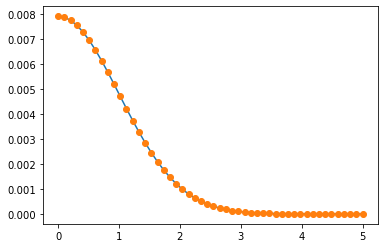

In [8]:
def F (x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

X = np.linspace(0,tmax,50)
F_Xi = F(Xi)

plt.plot(X, fourier_inverse_old(X,Xi,F_Xi))
plt.plot(X, fourier_inverse0(X,Xi,F_Xi), "o")
#plt.plot(X, np.exp(-X**2/2)/(2*np.pi), "x")
plt.show()

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


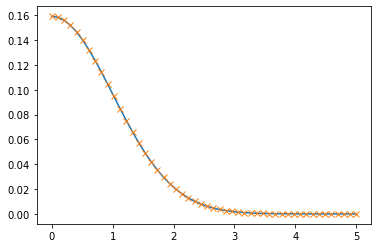

In [9]:
plt.plot(X, fourier_inverse(X,Xi,F_Xi))
plt.plot(X, np.exp(-X**2/2)/(2*np.pi), "x")
plt.show()

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


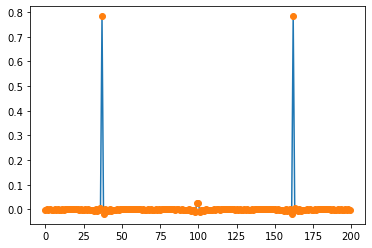

In [10]:
Wt = wt_real[:,0]

plt.plot(get_fourier_wt_old(Xi,Wt))
plt.plot(get_fourier_wt(Xi,Wt), "o")
plt.show()

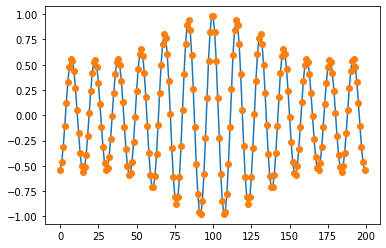

In [11]:
Wt = wt_real[:,2]

plt.plot(get_fourier_log_wt_old(Xi,Wt))

plt.plot(get_fourier_log_wt(Xi,Wt), "o")
plt.show()

# Expériences


## Fonctions générales

In [12]:
def draw(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    
    Xi=np.linspace(ximin,ximax,nbreaks_xi)
    tot=np.array([get_fourier_wt(Xi,wt[t]) for t in range(tmax)])

    plt.plot(range(tmax),np.real(tot))
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("Fw_t(xi)")
    plt.title(titre)
    plt.show()
    
def draw_log(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    
    Xi=np.linspace(ximin,ximax,nbreaks_xi)
    tot=np.log(np.array([get_fourier_wt(Xi,wt[t]) for t in range(tmax)]))

    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show()     
    
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    
    Xi=np.linspace(ximin,ximax,nbreaks_xi)
    tot=np.log(np.abs(np.array([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])))
    
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

In [13]:
def dessine_droites(wt,ximin,ximax,nbreaks_xi,tmax,titre):
    tot=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        Fu_t=get_fourier_log_wt(xi,wt[t])
        Fu_t=np.array(Fu_t)
        lnFu_t=np.log(np.abs(Fu_t))
        tot+=[lnFu_t]
    tot=np.array(tot)
    
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show()             

In [14]:
wt_sim_norm=normalise(wt_sim)
wt_real_norm=normalise(wt_real)
print(wt_sim_norm)
print(wt_real_norm)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.81680618 0.98298851 0.         ... 0.74174247 0.47191252 0.99937605]
 [0.81680618 0.98298851 0.         ... 0.74174247 0.47191252 0.99937605]
 [0.81680618 0.98298851 0.         ... 0.74174247 0.47191252 0.99937605]]
[[  1.           1.           1.         ...   1.                  nan
           nan]
 [  1.33333333   1.           1.         ...   1.                  nan
           nan]
 [  1.66666667   0.92063428   1.         ...   1.13496785          nan
           nan]
 ...
 [220.           0.7833131    0.51603489 ...          nan          nan
           nan]
 [220.33333333   0.7833131    0.51603489 ...          nan          nan
           nan]
 [220.66666667   0.7833131    0.51603489 ...          nan          nan
           nan]]


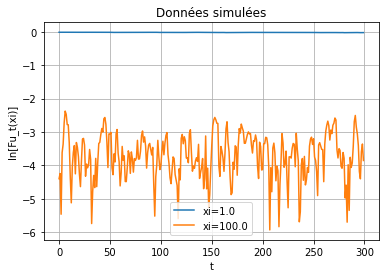

In [15]:
# tests fonctions:
dessine_droites(wt_real_norm[20:],ximin=1,ximax=100,nbreaks_xi=2,tmax=300,titre="Données simulées")

In [16]:
wt_sim_norm2=normalise2(wt_sim,1)
wt_real_norm2=normalise2(wt_real,1)

# Travail sur les petites valeurs de xi

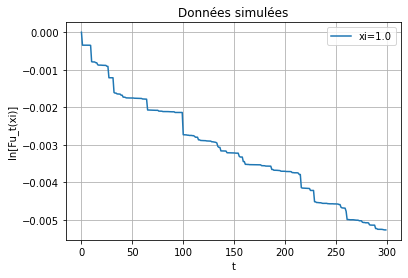

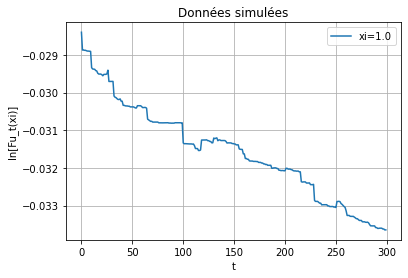

In [17]:
dessine_droites(wt_sim_norm2,ximin=1,ximax=10000,nbreaks_xi=1,tmax=300,titre="Données simulées")
dessine_droites(wt_sim,ximin=1,ximax=10000,nbreaks_xi=1,tmax=300,titre="Données simulées")

$\to$ jolies droites, formes similaires mais : pas du tout la même pente !

## Formule avec les EDP

D'après les calculs, la fonction $$t\mapsto \ln\mathbb{E}[e^{-i\xi X_t}]$$ est affine (pour tout $\xi$ fixé): on va tracer les graphes de ces fonctions, et vérifier qu'on obtient à peu près des droites !


### Données non normalisées

#### Petites valeurs de $\xi$ :

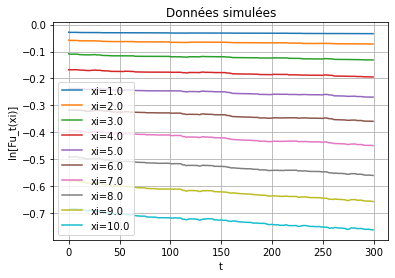

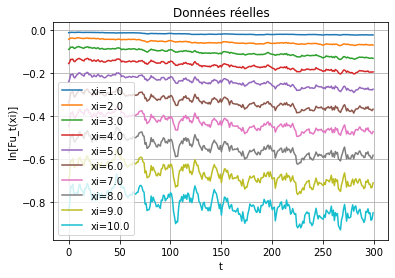

In [18]:
draw_log_log(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")

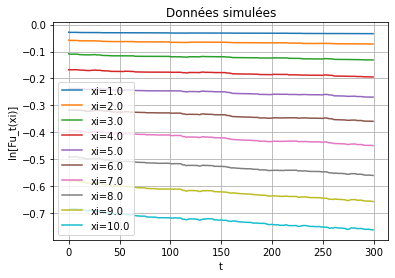

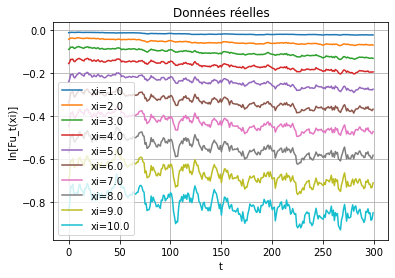

In [19]:
draw_log_log(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")

On obtient des droites plutôt satisfaisantes !

#### Grandes valeurs de $\xi$ :

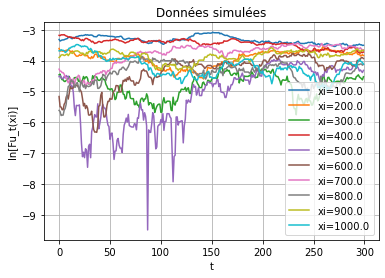

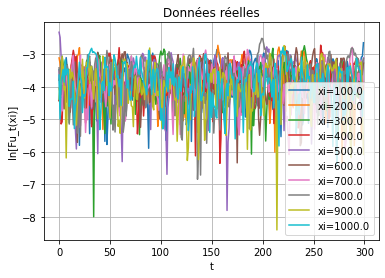

In [20]:
draw_log_log(wt_sim,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_real,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données réelles")

Les résultats ne sont plus du tout satisfaisants, même pour les données  simulées.

### Données normalisées

#### Petites valeurs de $\xi$ :

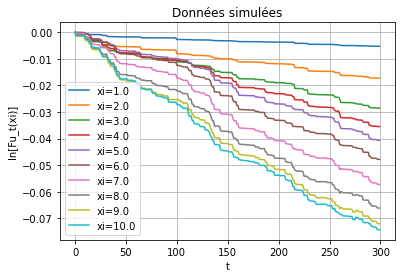

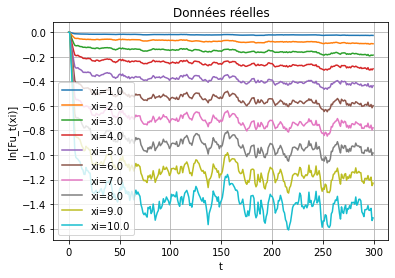

In [21]:
wt_sim_norm=normalise(wt_sim)
#wt_sim_nnorm=normalise(wt_sim_noise)
wt_real_norm=normalise(wt_real)

draw_log_log(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
#draw_log_log(wt_sim_nnorm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées bruitées")
draw_log_log(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")

#### Grandes valeurs de $\xi$ :

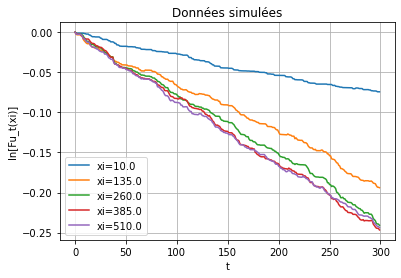

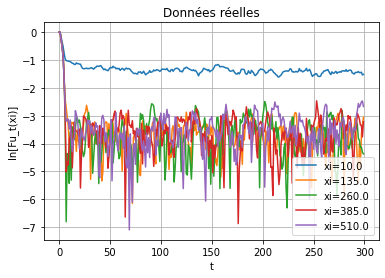

In [22]:
draw_log_log(wt_sim_norm,ximin=10,ximax=510,nbreaks_xi=5,tmax=300,titre="Données simulées")
#draw_log_log(wt_sim_nnorm,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données simulées bruitées")
draw_log_log(wt_real_norm,ximin=10,ximax=510,nbreaks_xi=5,tmax=300,titre="Données réelles")

Quand les données sont normalisées, les droites sont beaucoup plus crédibles (dans le cas des données simulées) : erreur dans le raisonnement ?

Quant aux données réelles, les résultats trouvés sont étranges...

### Valeur limite de la pente

Comme la transformée de Fourier tend vers 0 pour les grandes fréquences, on s'attend à ce que quand $\xi\to\infty$, la pente de $t\mapsto\ln\mathbb{E}[e^{-i\xi\ln X_t}]$ tende vers $-\lambda$. Vérifions cela...

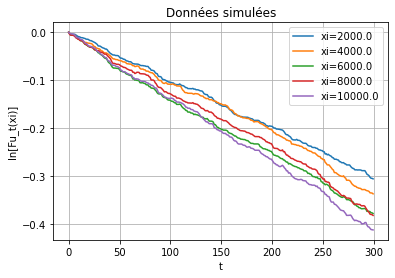

In [23]:
draw_log_log(wt_sim_norm,ximin=2000,ximax=10000,nbreaks_xi=5,tmax=300,titre="Données simulées")

On observe des droites de pentes similaires, à peu près $-1/300$. Comme une unité de temps correspond à 4 minutes, on a des droites de pente $-1/1200 min^{-1}$, qui correspondrait à une mutation toutes les $1200$ minutes. Dans la simulation, on a considéré un taux de mutation de $0,32$ par heure, soit une mutation toutes les $180$ minutes. Ça ne marche pas !

### Régression linéaire

On commence par faire des régression linéaire avec ce qui marche le mieux, à savoir les données simulées normalisées !

## Formule de la diapositive

D'après la formule indiquée sur la diapositive, la fonction $$t\mapsto \mathbb{E}[e^{-i\xi X_t}]$$ est affine (pour $\xi$ fixé). On va tracer son graphe et on s'attend à observer des droites !

### Données non normalisées

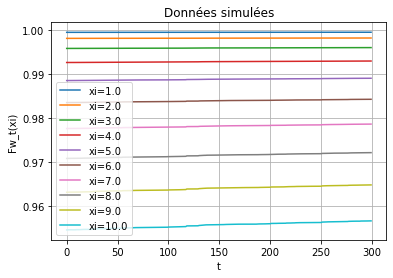

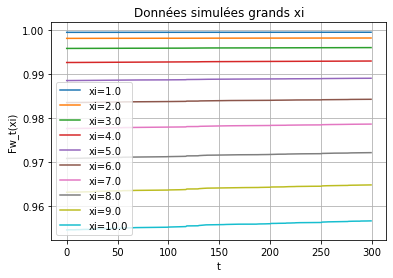

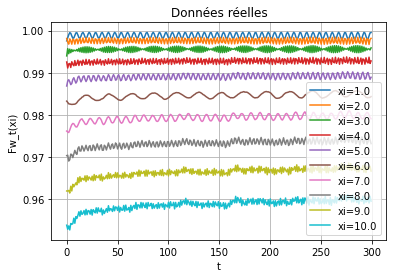

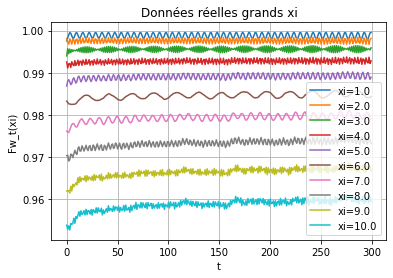

In [24]:
draw(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées grands xi")
draw(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")
draw(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles grands xi")

### Données normalisées

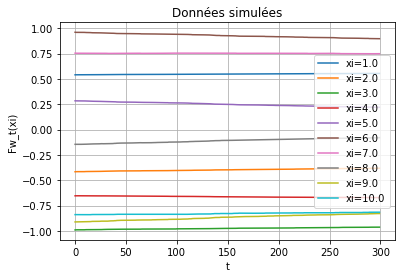

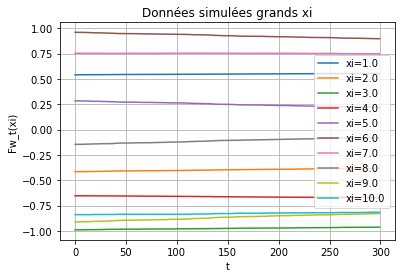

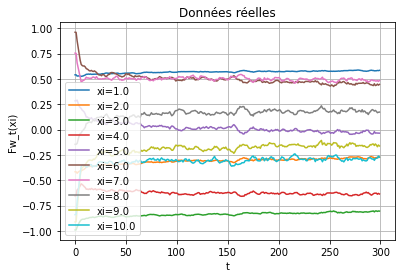

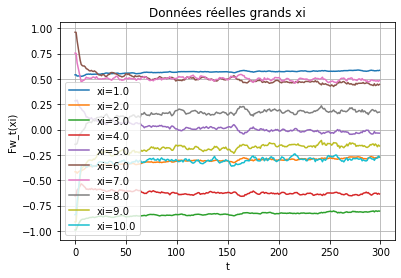

In [25]:
draw(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées grands xi")
draw(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")
draw(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles grands xi")